In [ ]:
import yfinance as yf


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
data = yf.download('ESCORTS.NS',period='5y',interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head(3)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-19,666.799988,686.000000,663.200012,672.450012,661.119995,1944087
2018-11-20,672.900024,678.950012,657.000000,659.650024,648.535706,1211705
2018-11-21,663.000000,666.900024,652.250000,661.599976,650.452820,1112032


In [ ]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
data = data.loc[:,["Adj Close"]].values

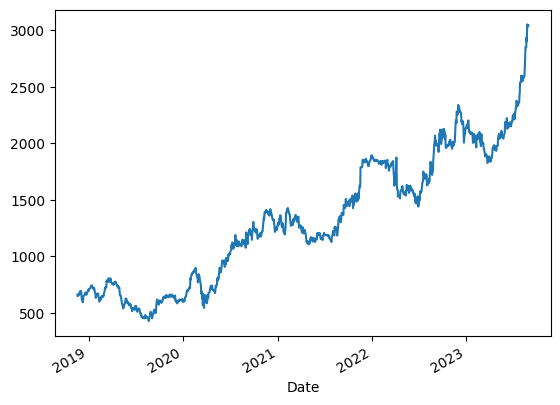

In [ ]:
plot = data_target.plot()


In [ ]:
#Check Length
print("Length of Data:{}".format(len(data)))
print("Length of Data_Target:{}".format(len(data_target)))

Length of Data:1236
Length of Data_Target:1182


In [ ]:
#Scaling Dataset
def scaledata(data_target):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    return data_target_scaled, scaler

In [ ]:
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
data_target_scaled

(1182,)
(1182,)


array([[0.08908496],
       [0.0842894 ],
       [0.08501996],
       ...,
       [1.        ],
       [0.99268337],
       [0.9976754 ]])

In [ ]:
data_test_scaled = scaledata(data_test)[0]

(104,)


In [ ]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)

    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)

    return x_patern,y_price

In [ ]:
train_pattern = createPatternSet(data_target_scaled,steps=50)


In [ ]:
x_train = train_pattern[0]
y_train = train_pattern[1]


In [ ]:
x_train.shape


(1132, 50, 1)

In [ ]:
y_train.shape


(1132,)

In [ ]:
x_train


array([[[0.08908496],
        [0.0842894 ],
        [0.08501996],
        ...,
        [0.10054941],
        [0.09005907],
        [0.07848225]],

       [[0.0842894 ],
        [0.08501996],
        [0.08505741],
        ...,
        [0.09005907],
        [0.07848225],
        [0.08354006]],

       [[0.08501996],
        [0.08505741],
        [0.08880401],
        ...,
        [0.07848225],
        [0.08354006],
        [0.08427065]],

       ...,

       [[0.66707323],
        [0.65472772],
        [0.66502197],
        ...,
        [0.95524271],
        [0.94247669],
        [0.97587791]],

       [[0.65472772],
        [0.66502197],
        [0.67015011],
        ...,
        [0.94247669],
        [0.97587791],
        [1.        ]],

       [[0.66502197],
        [0.67015011],
        [0.65871627],
        ...,
        [0.97587791],
        [1.        ],
        [0.99268337]]])

In [ ]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch

    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))

        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))

        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()

    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history

    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")



In [ ]:
RNN1 = StocksPriceRNN(x_train,y_train,50)


In [ ]:
RNN1.buildArchitecture(2,0)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [ ]:
RNN1.compiler()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [ ]:
history = RNN1.modelfit()


Epoch 1/50
29/29 [==============================] - 6s 78ms/step - loss: 0.3665 - val_loss: 0.1045
Epoch 2/50
29/29 [==============================] - 2s 55ms/step - loss: 0.2515 - val_loss: 0.0062
Epoch 3/50
29/29 [==============================] - 4s 133ms/step - loss: 0.1593 - val_loss: 0.0055
Epoch 4/50
29/29 [==============================] - 2s 64ms/step - loss: 0.1472 - val_loss: 0.0063
Epoch 5/50
29/29 [==============================] - 2s 57ms/step - loss: 0.1123 - val_loss: 0.0346
Epoch 6/50
29/29 [==============================] - 1s 50ms/step - loss: 0.0871 - val_loss: 0.0204
Epoch 7/50
29/29 [==============================] - 2s 56ms/step - loss: 0.0794 - val_loss: 0.0066
Epoch 8/50
29/29 [==============================] - 2s 83ms/step - loss: 0.0575 - val_loss: 0.0092
Epoch 9/50
29/29 [==============================] - 2s 57ms/step - loss: 0.0486 - val_loss: 0.0080
Epoch 10/50
29/29 [==============================] - 3s 115ms/step - loss: 0.0402 - val_loss: 0.0057
Epoch 1

In [ ]:
#Prepare Test Data
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)




In [ ]:
test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]

In [ ]:
#Predict the value for test set
y_test

array([0.67015011, 0.65871627, 0.66376849, 0.65843139, 0.65609517,
       0.67305609, 0.67298017, 0.67298017, 0.6939583 , 0.69140511,
       0.67987758, 0.69912189, 0.6919196 , 0.68043012, 0.70822965,
       0.71167831, 0.72034777, 0.72015724, 0.74286937, 0.73820119,
       0.73096076, 0.72501595, 0.73065588, 0.73027481, 0.73601001,
       0.73877281, 0.76329505, 0.77053548, 0.80387958, 0.80487032,
       0.81405427, 0.82731572, 0.80870014, 0.81862718, 0.80877634,
       0.82506731, 0.82358116, 0.82177105, 0.81965606, 0.8244957 ,
       0.86715707, 0.90050117, 0.92363253, 0.92245115, 0.95524271,
       0.94247669, 0.97587791, 1.        , 0.99268337, 0.9976754 ,
       1.07669143, 1.04106088, 1.03140058, 0.99434099, 1.00407749,
       1.03841242, 1.0353066 , 1.05102596, 1.05380783, 1.01775815,
       1.02591313, 1.025856  , 1.03827901, 1.04521456, 1.03246761,
       1.0213593 , 1.02859973, 1.06994641, 1.06127694, 1.10233782,
       1.05899049, 1.05091171, 1.02787563, 1.05487486, 1.07295

In [ ]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 1s 15ms/step


(104, 1)

In [ ]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
output


array([[2130.0425],
       [2125.7314],
       [2127.1387],
       [2128.681 ],
       [2133.6775],
       [2131.0352],
       [2126.9072],
       [2135.7598],
       [2139.8193],
       [2145.2207],
       [2148.3613],
       [2160.094 ],
       [2169.556 ],
       [2168.1128],
       [2177.2048],
       [2185.1594],
       [2188.477 ],
       [2198.4019],
       [2209.2346],
       [2224.183 ],
       [2238.4058],
       [2237.9883],
       [2242.4082],
       [2246.826 ],
       [2247.143 ],
       [2245.7158],
       [2250.4795],
       [2258.7314],
       [2270.8547],
       [2283.1504],
       [2304.4321],
       [2328.338 ],
       [2344.7793],
       [2356.7102],
       [2367.9062],
       [2363.2942],
       [2366.0361],
       [2374.0242],
       [2368.9968],
       [2369.8274],
       [2371.116 ],
       [2374.4272],
       [2396.149 ],
       [2425.404 ],
       [2451.2686],
       [2484.4429],
       [2499.1182],
       [2501.2068],
       [2523.3784],
       [2532.874 ],


In [ ]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="Green",label="Org value")
    plt.plot(output,color="Yellow",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()


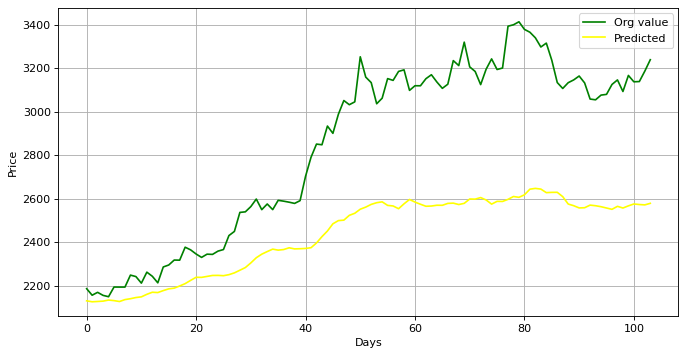

In [ ]:
plotting(org_vals,output)


In [ ]:
#Build a for loop with some iterations
for steps in [7,30,90]:
    for epoch in [20,30,50]:
        #prepare train data
        train_pattern = createPatternSet(data_target_scaled,steps=steps)
        #prepare test data
        test = data[len(data) - len(data_test) - steps:]
        test = scaler.transform(test)

        test_pattern = createPatternSet(test,steps=steps)
        x_test = test_pattern[0]
        y_test = test_pattern[1]
        #Build Model
        RNN1 = StocksPriceRNN(x_train,y_train,epoch)
        RNN1.buildArchitecture(2,0)
        RNN1.compiler()
        #fit model
        history = RNN1.modelfit()
        #Predict Values
        pred = RNN1.model.predict(x=x_test)
        output = scaler.inverse_transform(pred)
        #visualise
        print("Plotting for Steps {} and Epoch {}".format(steps,epoch))
        plotting(org_vals,output)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)               

ValueError: ignored

In [ ]:
#Long Short Term Memory
class LstmModel(StocksPriceRNN):
    StocksPriceRNN.model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        super().__init__(x_train,y_train,epoch)

    def buildArchitecture(self,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.LSTM(StocksPriceRNN.neurons,input_shape=(None,1)))
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

In [ ]:
LSTM = LstmModel(x_train,y_train,epoch=50)


In [ ]:
LSTM.changeBatchSize(1)

Changed!


In [ ]:
LSTM.changeNeurons(10)

Changed!


In [ ]:
LSTM.buildArchitecture()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
LSTM.compiler()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = LSTM.modelfit()

Epoch 1/50
905/905 [==============================] - 15s 13ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 2/50
905/905 [==============================] - 12s 13ms/step - loss: 5.6551e-04 - val_loss: 0.0015
Epoch 3/50
905/905 [==============================] - 12s 14ms/step - loss: 4.5656e-04 - val_loss: 0.0015
Epoch 4/50
905/905 [==============================] - 13s 14ms/step - loss: 4.0754e-04 - val_loss: 6.8683e-04
Epoch 5/50
905/905 [==============================] - 12s 14ms/step - loss: 3.5721e-04 - val_loss: 6.3155e-04
Epoch 6/50
905/905 [==============================] - 11s 12ms/step - loss: 3.1361e-04 - val_loss: 4.9005e-04
Epoch 7/50
905/905 [==============================] - 12s 13ms/step - loss: 2.8267e-04 - val_loss: 0.0010
Epoch 8/50
905/905 [==============================] - 13s 14ms/step - loss: 2.5880e-04 - val_loss: 3.9301e-04
Epoch 9/50
905/905 [==============================] - 12s 14ms/step - loss: 2.4811e-04 - val_loss: 4.9498e-04
Epoch 10/50
905/905 [=========

4/4 [==============================] - 0s 4ms/step


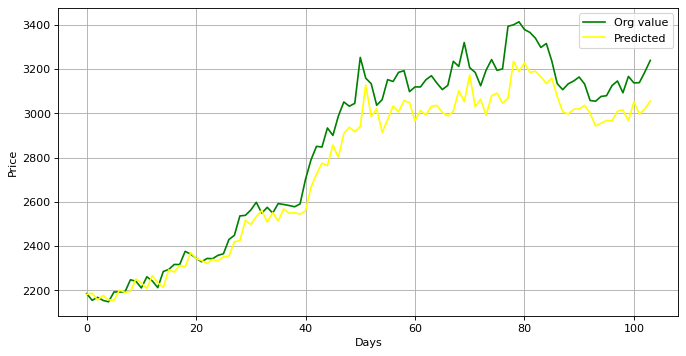

In [ ]:
pred = LSTM.model.predict(x_test)
output = scaler.inverse_transform(pred)

plotting(org_vals,output)


Changed!
Changed!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                  

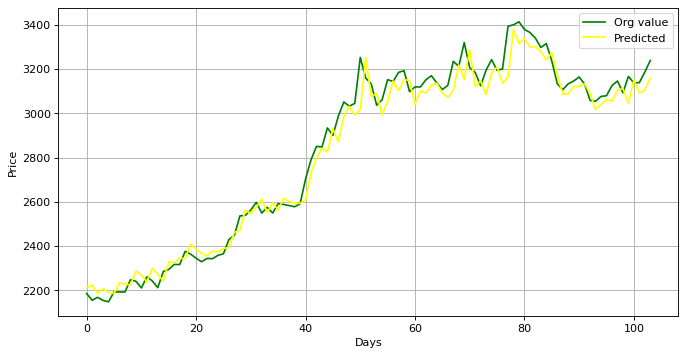

Changed!
Changed!
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                  

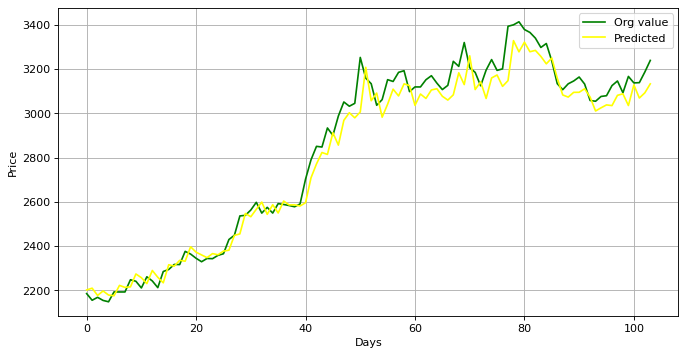

Changed!
Changed!
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12)                672       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12)                672       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                  

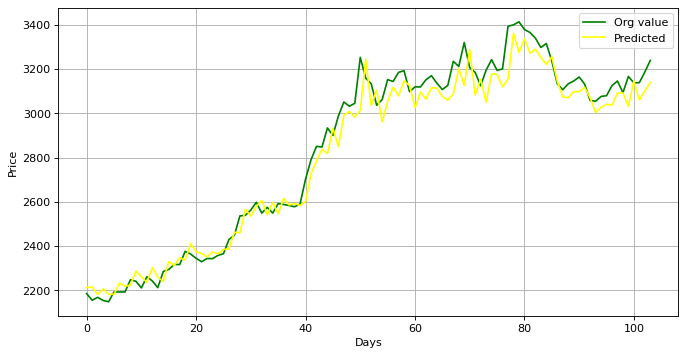

Changed!
Changed!
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                  

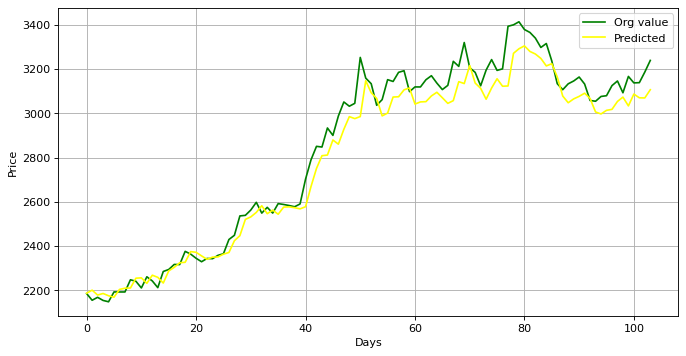

Changed!
Changed!
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                480       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                480       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                  

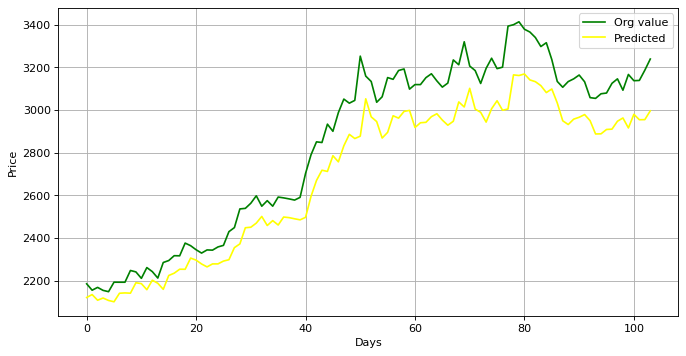

Changed!
Changed!
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12)                672       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12)                672       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                

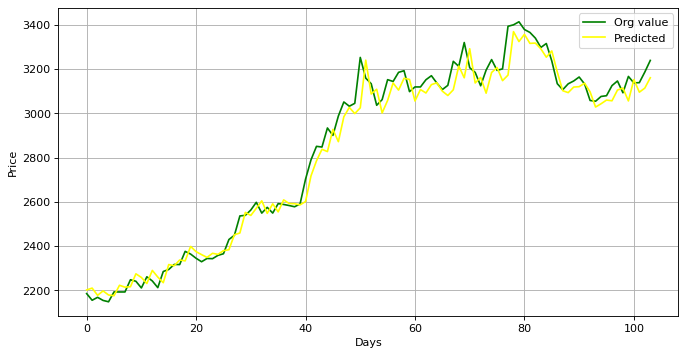

Changed!
Changed!
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 8)                 320       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 8)                 320       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                

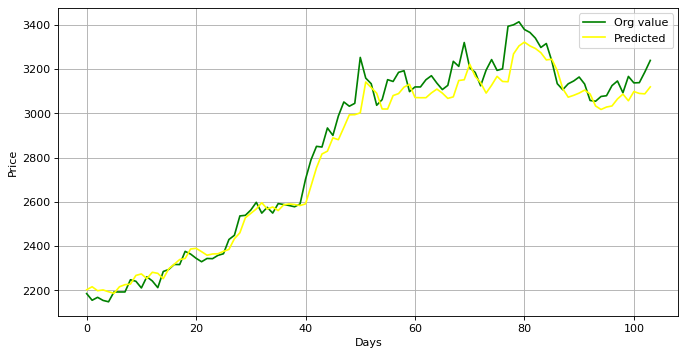

Changed!
Changed!
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                480       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                480       
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                

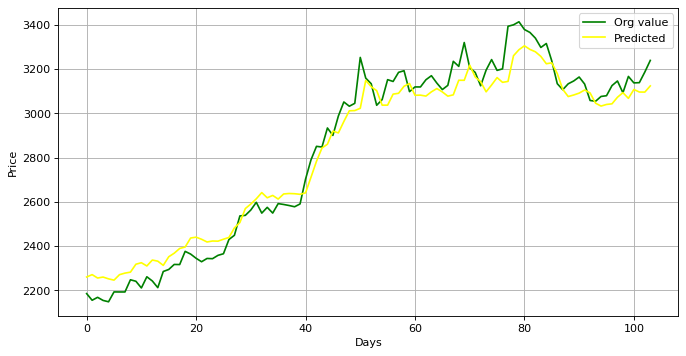

Changed!
Changed!
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 12)                672       
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 12)                672       
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                

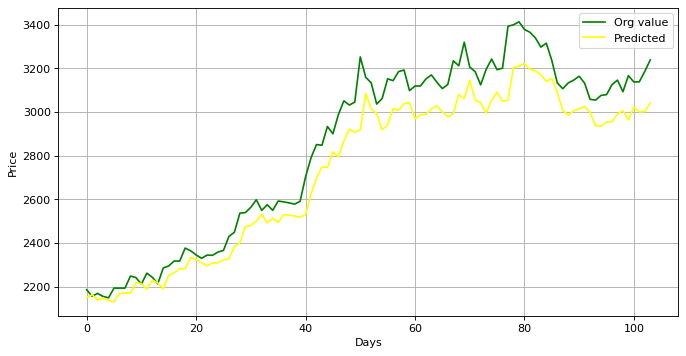

Changed!
Changed!
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 8)                 320       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 8)                 320       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                

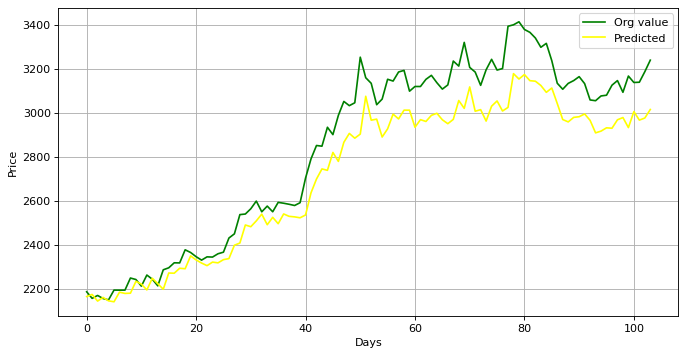

Changed!
Changed!
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10)                480       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10)                480       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                

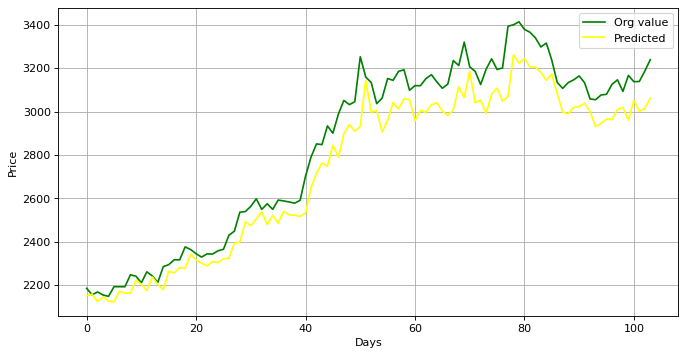

Changed!
Changed!
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12)                672       
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12)                672       
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                                

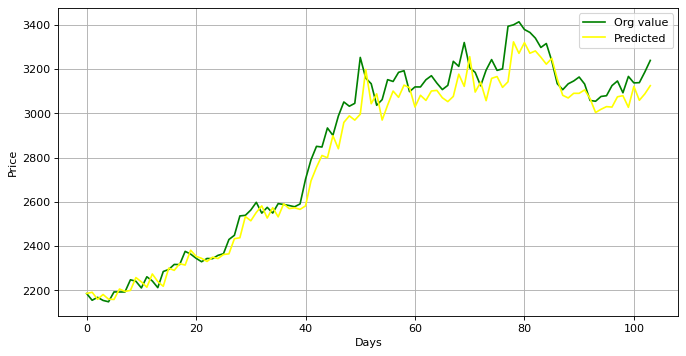

Changed!
Changed!
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 8)                 320       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 8)                 320       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                

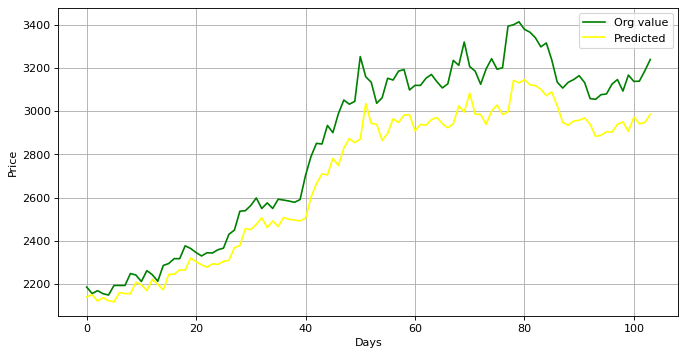

Changed!
Changed!
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10)                480       
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10)                480       
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                

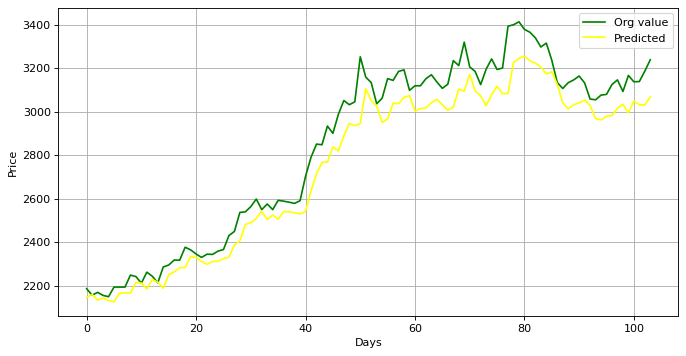

Changed!
Changed!
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 12)                672       
                                                                 
 dense_17 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 12)                672       
                                                                 
 dense_17 (Dense)            (None, 1)                 13        
                                                

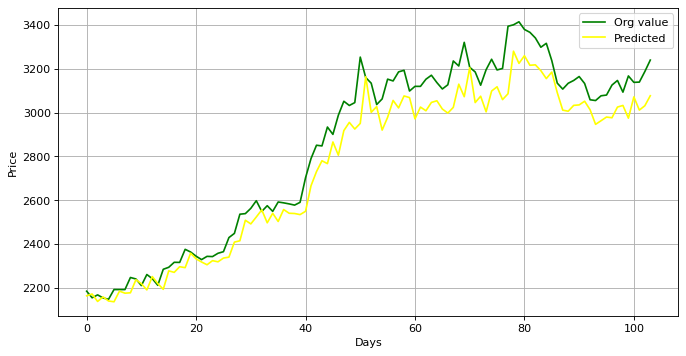

Changed!
Changed!
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8)                 320       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8)                 320       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                

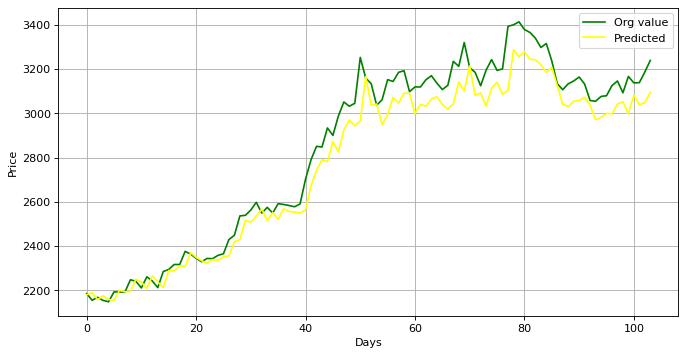

Changed!
Changed!
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10)                480       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10)                480       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                

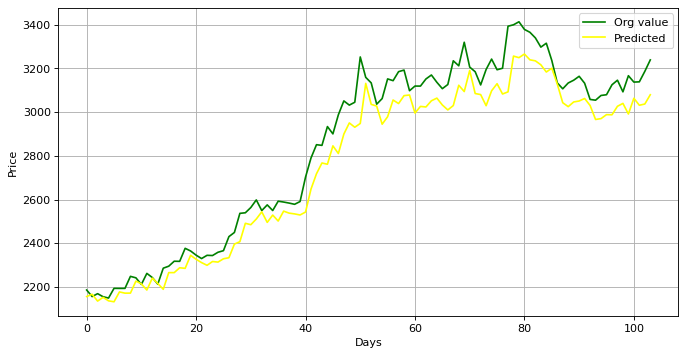

Changed!
Changed!
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 12)                672       
                                                                 
 dense_20 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 12)                672       
                                                                 
 dense_20 (Dense)            (None, 1)                 13        
                                                

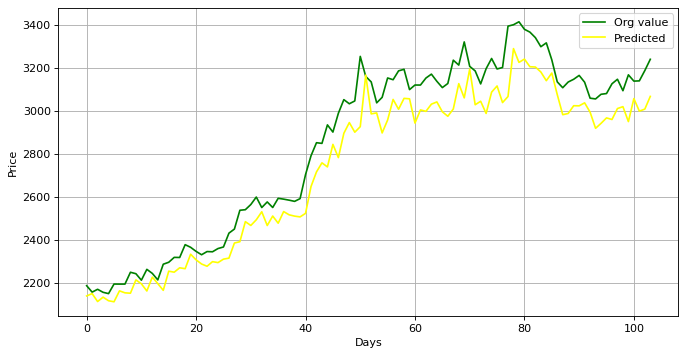

Changed!
Changed!
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 8)                 320       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 8)                 320       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                

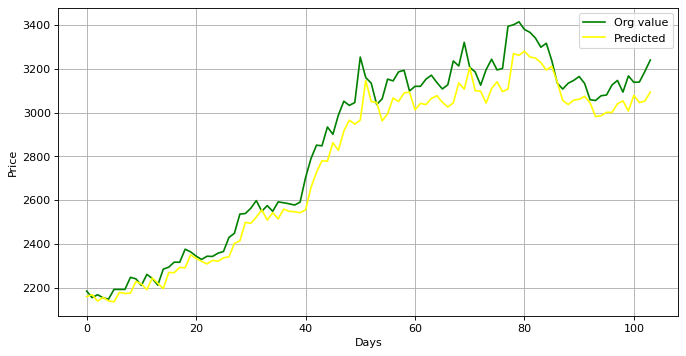

Changed!
Changed!
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10)                480       
                                                                 
 dense_22 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10)                480       
                                                                 
 dense_22 (Dense)            (None, 1)                 11        
                                                

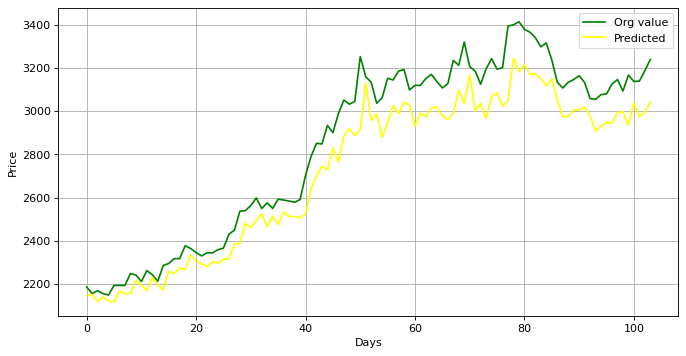

Changed!
Changed!
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 12)                672       
                                                                 
 dense_23 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 12)                672       
                                                                 
 dense_23 (Dense)            (None, 1)                 13        
                                                

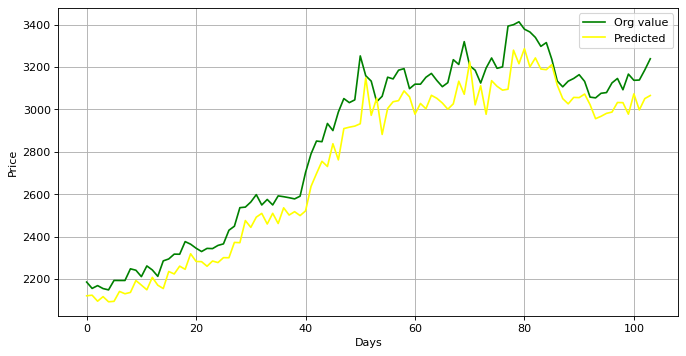

Changed!
Changed!
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 8)                 320       
                                                                 
 dense_24 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 8)                 320       
                                                                 
 dense_24 (Dense)            (None, 1)                 9         
                                                

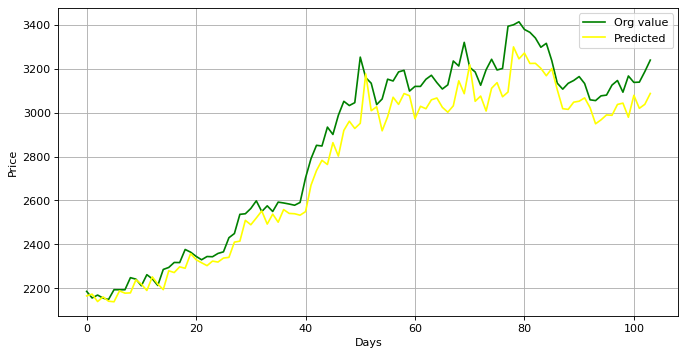

Changed!
Changed!
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 10)                480       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 10)                480       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                

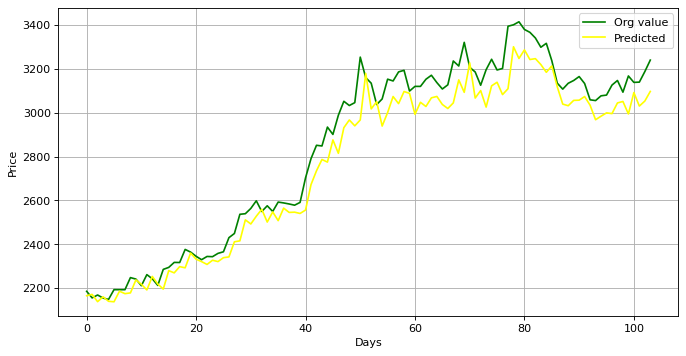

Changed!
Changed!
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 12)                672       
                                                                 
 dense_26 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 12)                672       
                                                                 
 dense_26 (Dense)            (None, 1)                 13        
                                                

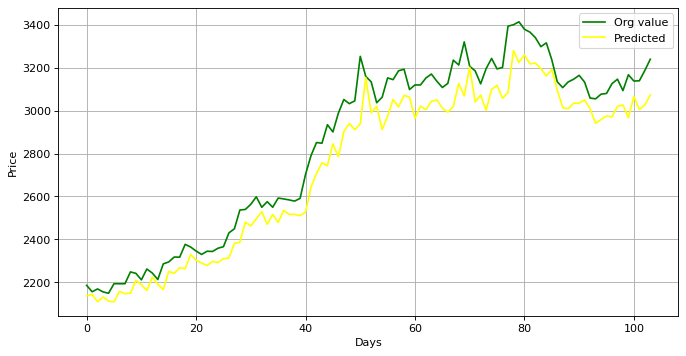

Changed!
Changed!
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 8)                 320       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 8)                 320       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                

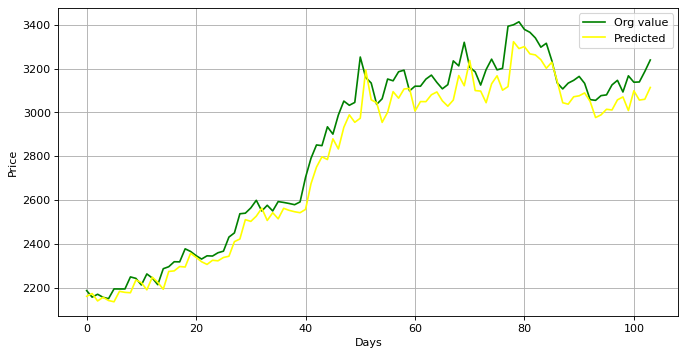

Changed!
Changed!
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 10)                480       
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 10)                480       
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                

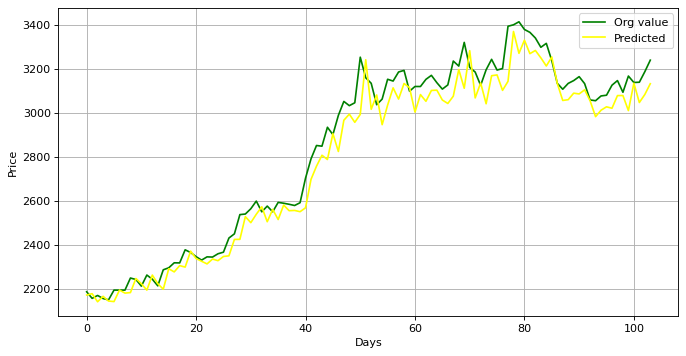

Changed!
Changed!
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 12)                672       
                                                                 
 dense_29 (Dense)            (None, 1)                 13        
                                                                 
Total params: 685 (2.68 KB)
Trainable params: 685 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 12)                672       
                                                                 
 dense_29 (Dense)            (None, 1)                 13        
                                                

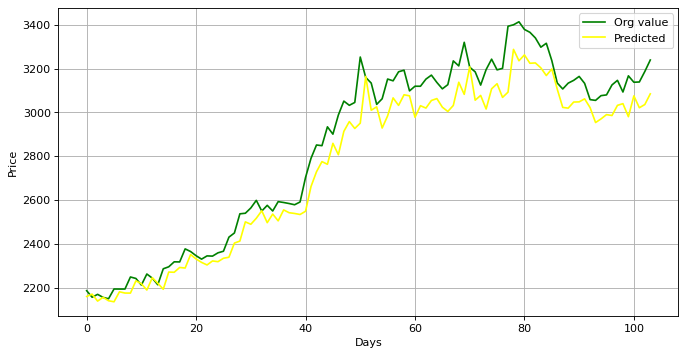

In [ ]:
#27 Iterations!!!!!!!!!!!!!!!!!!!
for epch in [50,60,70]:
    for batch in [2, 3,4]:
        for neurons in [8,10,12]:
            LSTM2 = LstmModel(x_train,y_train,epoch=epch)
            LSTM2.changeBatchSize(batch)
            LSTM2.changeNeurons(neurons)

            LSTM2.buildArchitecture()
            LSTM2.compiler()
            history = LSTM2.modelfit()

            pred = LSTM2.model.predict(x_test)
            output = scaler.inverse_transform(pred)


            print("For epch {} and batch {}".format(epch,batch))
            plotting(org_vals,output)


Changed!
Changed!
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10)                480       
                                                                 
 dense_30 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10)                480       
                                                                 
 dense_30 (Dense)            (None, 1)                 11        
                                                

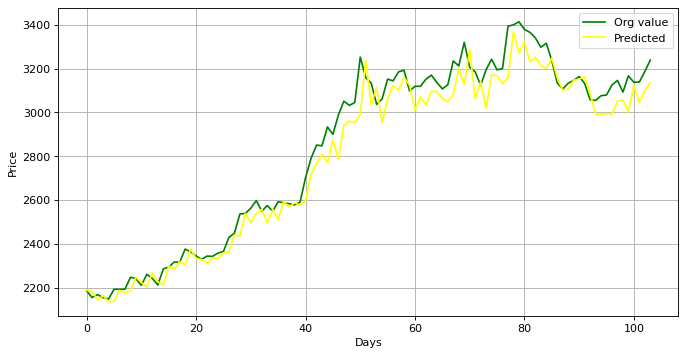

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Final Model Output
#prepare train data
train_pattern = createPatternSet(data_target_scaled,steps=90)
test = data[len(data) - len(data_tesßt) - 90:]
test = scaler.transform(test)
test_pattern = createPatternSet(test,steps=90)
x_test = test_pattern[0]
y_test = test_pattern[1]
LSTM2 = LstmModel(x_tßrain,y_train,epoch=200)
LSTM2.changeBatchSize(2)
LSTM2.changeNeurons(10)

LSTM2.buildArchitecture()
LSTM2.compiler()
history = LSTM2.modelfit()
pred = LSTM2.model.predict(x_test)
pred = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))
print("For epch {}, neurons {} and batch {}".format(200,10,2))
plotting(org_vals,pred)

In [ ]:
curr_data = yf.download('ESCORTS.NS',start="2021-02-1",end="2021-06-22",interval='1d')
print("Length of Data: ",len(curr_data))
curr_data = curr_data["Adj Close"]

def futurePrediciton1D(curr_data,start="2021-02-1",end="2021-06-19"):
    '''
    '''
    curr_scaled = scaledata(curr_data)[0]
    scaler = scaledata(curr_data)[1]

    #flatten into list
    x_data = list(curr_scaled.flatten())
    #convert into 3D
    x_data = np.array(x_data)
    x_data = x_data.reshape(1,len(x_data),1)

    #Predict
    nextDay = LSTM2.model.predict(x=x_data)
    nextDay = scaler.inverse_transform(nextDay.reshape(-1,1))

    nextDay = nextDay[-1][0]
    print("Prediction: {}".format(nextDay))
    #convert into dataframe again
    curr_data = pd.DataFrame(curr_data)
    curr_data.reset_index(inplace=True)
    adj_cl = curr_data[['Adj Close']]

    #concatenate new value
    adj_cl.loc[len(adj_cl.index)] = [nextDay]

    return adj_cl

[*********************100%%**********************]  1 of 1 completed
Length of Data:  95
